# This notebook is used to evaluate the performance of trained model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import os
from glob import glob
from pathlib import Path
from typing import List, Union

import yaml
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [29]:
from ner_ehr.data.ehr import EHR
from ner_ehr.data.utils import df_to_namedtuples
from ner_ehr.utils import read_annotatedtuples, load_np
from ner_ehr.data.variables import AnnotationTuple

from ner_ehr.training.pl_models import LitLSTMNERTagger
from ner_ehr.training.datasets import EHRDataset, EHRBatchCollator
from ner_ehr.data.vocab import TokenEntityVocab
from ner_ehr.decode import argmax_decode

In [4]:
LOG_DIR = "../logs/ner_ehr_lstm"
VERSION = 0
DEFAULT_DEVICE_TYPE = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu")
PROCESSED_DIR_TEST = "../processed/test"

hparams = yaml.safe_load(
    open(os.path.join(LOG_DIR, f"version_{VERSION}", "hparams.yaml")))

ckpt = glob(os.path.join(LOG_DIR, f"version_{VERSION}", "checkpoints", "*.ckpt"))[0]
ckpt

'../logs/ner_ehr_lstm/version_0/checkpoints/epoch=14-step=1409-val_loss=0.104.ckpt'

In [5]:
train_annotatedtuples = read_annotatedtuples(
    dir=hparams["parser_args"]["processed_data_dir_train"])

vocab = TokenEntityVocab(to_lower=True if hparams["parser_args"]["to_lower"]=="Y" else False)
vocab.fit(annotatedtuples=train_annotatedtuples)

In [6]:
metrics = pd.read_csv(
    os.path.join(LOG_DIR, f"version_{VERSION}", "metrics.csv"),
    engine="python")

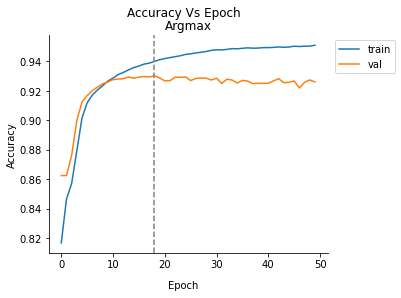

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 4), sharey=True)
ax.plot(
    metrics[~metrics["train_argmax_acc_epoch"].isna()]["epoch"],
    metrics[~metrics["train_argmax_acc_epoch"].isna()]["train_argmax_acc_epoch"], 
    label="train")
ax.plot(
    metrics[~metrics["val_argmax_acc_epoch"].isna()]["epoch"],
    metrics[~metrics["val_argmax_acc_epoch"].isna()]["val_argmax_acc_epoch"], 
    label="val")
best_argmax_acc_val_epoch = metrics[
    ~metrics["val_argmax_acc_epoch"].isna()][
    ["epoch", "val_argmax_acc_epoch"]
].sort_values("val_argmax_acc_epoch", ascending=False).values[0][0]
ax.axvline(x=best_argmax_acc_val_epoch, ls="dashed", color="grey")
ax.set_title("Argmax")
sns.despine(ax=ax)


ax.legend(bbox_to_anchor=(1.01, 1.))


fig.text(x=.5, y=0., s="Epoch", ha="center")
fig.text(x=0.01, y=0.5, s="Accuracy", va="center", rotation=90)
plt.suptitle("Accuracy Vs Epoch")
plt.show()

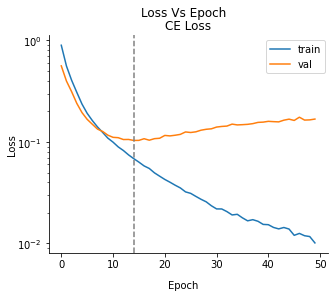

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(
    metrics[~metrics["train_ce_loss_epoch"].isna()]["epoch"],
    metrics[~metrics["train_ce_loss_epoch"].isna()]["train_ce_loss_epoch"], 
    label="train")
ax.plot(
    metrics[~metrics["val_loss_epoch"].isna()]["epoch"],
    metrics[~metrics["val_loss_epoch"].isna()]["val_loss_epoch"], 
    label="val")
min_val_loss_epoch = metrics[
    ~metrics["val_loss_epoch"].isna()][
    ["epoch", "val_loss_epoch"]
].sort_values("val_loss_epoch").values[0][0]
ax.axvline(x=min_val_loss_epoch, ls="dashed", color="grey")
ax.set_title("CE Loss")
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.))

ax.set_yscale("log")
fig.text(x=.5, y=0., s="Epoch", ha="center")
fig.text(x=0.01, y=0.5, s="Loss", va="center", rotation=90)
plt.suptitle("Loss Vs Epoch")
plt.show()

In [22]:
metrics[[col for col in metrics.columns if col.startswith("train_argmax_acc_label") and col.endswith("epoch")]].dropna()

,train_argmax_acc_label=0_epoch,train_argmax_acc_label=1_epoch,train_argmax_acc_label=2_epoch,train_argmax_acc_label=3_epoch,train_argmax_acc_label=4_epoch,train_argmax_acc_label=5_epoch,train_argmax_acc_label=6_epoch,train_argmax_acc_label=7_epoch,train_argmax_acc_label=8_epoch,train_argmax_acc_label=9_epoch,train_argmax_acc_label=10_epoch,train_argmax_acc_label=11_epoch,train_argmax_acc_label=12_epoch,train_argmax_acc_label=13_epoch,train_argmax_acc_label=14_epoch,train_argmax_acc_label=15_epoch,train_argmax_acc_label=16_epoch,train_argmax_acc_label=17_epoch,train_argmax_acc_label=18_epoch,train_argmax_acc_label=19_epoch
106,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808,0.816808
213,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469,0.846469
320,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128,0.857128
427,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364,0.879364
534,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550,0.901550
641,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962,0.911962
748,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210,0.917210
855,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650,0.920650
962,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540,0.923540
1069,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730,0.926730


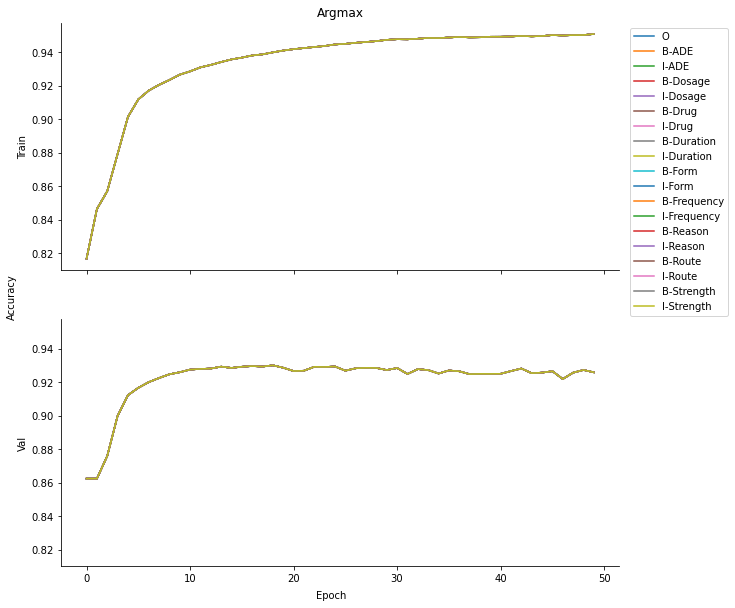

In [21]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, sharey=True)
for col in metrics.columns:
    if "label=0" in col:
        continue
    if col.startswith("train_argmax_acc_label") and col.endswith("epoch"):
        entity = vocab.label_to_entity(int(col.split("=")[1].split("_")[0]))[0]
        axes[0].plot(
            metrics[~metrics[col].isna()]["epoch"],
            metrics[~metrics[col].isna()][col], 
            label=entity)
    sns.despine(ax=axes[0])
        
    if col.startswith("val_argmax_acc_label") and col.endswith("epoch"):
        entity = vocab.label_to_entity(int(col.split("=")[1].split("_")[0]))[0]
        axes[1].plot(
            metrics[~metrics[col].isna()]["epoch"],
            metrics[~metrics[col].isna()][col], 
            label=entity)
    sns.despine(ax=axes[1])
    
axes[0].set_ylabel("Train")
axes[1].set_ylabel("Val")
axes[0].set_title("Argmax")
axes[0].legend(bbox_to_anchor=(1.01, 1.))
fig.text(x=.5, y=0.08, s="Epoch", ha="center")
fig.text(x=0.05, y=0.5, s="Accuracy", va="center", rotation=90)
plt.show()

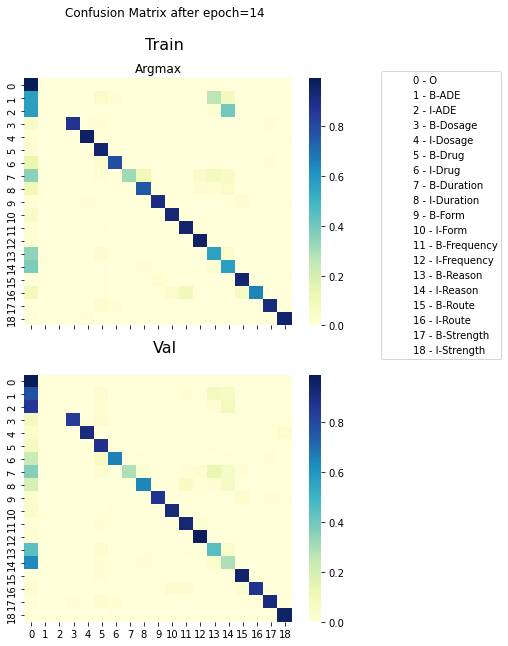

In [28]:
epoch = 14
cm_argmax_train = load_np(
    os.path.join(LOG_DIR, f"version_{VERSION}", f"train_cm_argmax_epoch={epoch}.npy"))
cm_argmax_train = cm_argmax_train/cm_argmax_train.sum(axis=1, keepdims=True)

cm_argmax_val = load_np(
    os.path.join(LOG_DIR, f"version_{VERSION}", f"val_cm_argmax_epoch={epoch}.npy"))
cm_argmax_val = cm_argmax_val/cm_argmax_val.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(nrows=2, figsize=(6, 10), sharex=True, sharey=True)
sns.heatmap(cm_argmax_train[1:,1:], cmap="YlGnBu", ax=axes[0])
sns.heatmap(cm_argmax_val[1:,1:], cmap="YlGnBu", ax=axes[1])

axes[0].set_title("Argmax")

legend_elements = []
for label, entity in vocab._label_to_entity.items():
    if label == 0:
        continue
    legend_elements.append(Line2D([0], [0], lw=0, label=f"{label-1} - {entity}"))
axes[0].legend(handles=legend_elements, bbox_to_anchor=(1.8,1.05))
fig.text(s="Train", x=.45, y=.92, ha="center", fontdict={"fontsize": 16})
fig.text(s="Val", x=.45, y=.5, ha="center", fontdict={"fontsize": 16})
plt.suptitle(t=f"Confusion Matrix after epoch={epoch}", x=.45, y=.98)
plt.show()

In [30]:
lit_lstm = LitLSTMNERTagger(
    embedding_dim=hparams["embedding_dim"],
    vocab_size=hparams["vocab_size"],
    hidden_size=hparams["hidden_size"],
    num_classes=hparams["num_classes"],
    num_lstm_layers=hparams["num_lstm_layers"],
    lstm_dropout=hparams["lstm_dropout"],
    bidirectional=hparams["bidirectional"],
)

lit_lstm.load_state_dict(
    torch.load(
        ckpt, 
        map_location=DEFAULT_DEVICE_TYPE)["state_dict"],
)

<All keys matched successfully>

In [31]:
test_ds = EHRDataset(
    dir=PROCESSED_DIR_TEST, 
    vocab=vocab, 
    seq_length=hparams["parser_args"]["seq_len"], 
    annotated=True)

collate_fn = EHRBatchCollator(return_meta=True)
test_dl = DataLoader(
    dataset = test_ds, 
    collate_fn=collate_fn,
    batch_size=64, 
    shuffle=False)

In [34]:
test_true = []
test_pred = []

for X, Y, Meta in tqdm(test_dl, leave=False, position=0):
    with torch.no_grad():
        Y_hat = lit_lstm(X)
        argmax_preds = argmax_decode(emissions=Y_hat)
    
        
    for meta, argmax_pred in zip(Meta, argmax_preds):
        # converting int labels to string entities
        # taking labels before padding (using meta information to identify true length of sequence)
        argmax_pred = vocab.label_to_entity(labels=argmax_pred[:len(meta)].tolist())
        
        test_true += [tup for tup in meta]
        test_pred += [tup[:-1] + [arg] for tup, arg in zip(meta, argmax_pred)]

KeyboardInterrupt: 

In [15]:
df_test_true = pd.DataFrame(test_true, columns=AnnotationTuple._fields)
df_test_pred = pd.DataFrame(test_pred, columns=list(AnnotationTuple._fields)[:-1] + ["argmax_entity"])
df_test_true.to_csv(os.path.join(LOG_DIR, f"version_{VERSION}", "test_true.csv"), index=False)
df_test_pred.to_csv(os.path.join(LOG_DIR, f"version_{VERSION}", "test_pred.csv"), index=False)

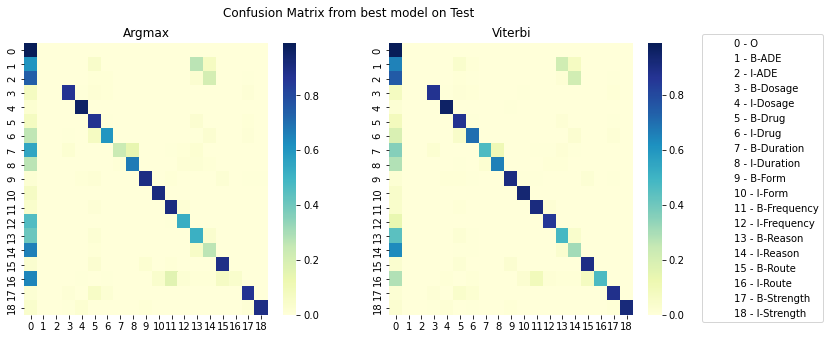

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
cm_argmax_test = confusion_matrix(
    y_true=vocab.entity_to_label(df_test_true["entity"].values.tolist()), 
    y_pred=vocab.entity_to_label(df_test_pred["argmax_entity"].values.tolist()),
    normalize="true", 
    labels=np.arange(vocab.num_uniq_entities))
cm_viterbi_test = confusion_matrix(
    y_true=vocab.entity_to_label(df_test_true["entity"].values.tolist()), 
    y_pred=vocab.entity_to_label(df_test_pred["viterbi_entity"].values.tolist()),
    normalize="true", 
    labels=np.arange(vocab.num_uniq_entities))
sns.heatmap(cm_argmax_test[1:,1:], cmap="YlGnBu", ax=ax1)
sns.heatmap(cm_viterbi_test[1:,1:], cmap="YlGnBu", ax=ax2)
ax1.set_title("Argmax")
ax2.set_title("Viterbi")
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.8,1.05))
plt.suptitle(t="Confusion Matrix from best model on Test")
plt.show()

In [17]:
print(classification_report(
    y_true=df_test_true["entity"].values, 
    y_pred=df_test_pred["argmax_entity"].values))

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ADE       0.00      0.00      0.00       672
    B-Dosage       0.90      0.87      0.88      2681
      B-Drug       0.86      0.87      0.87     10582
  B-Duration       0.81      0.24      0.36       378
      B-Form       0.94      0.90      0.92      4359
 B-Frequency       0.93      0.91      0.92      4012
    B-Reason       0.41      0.52      0.46      2590
     B-Route       0.94      0.89      0.92      3513
  B-Strength       0.92      0.87      0.90      4230
       I-ADE       0.00      0.00      0.00       498
    I-Dosage       0.95      0.96      0.96      5476
      I-Drug       0.75      0.60      0.67      1878
  I-Duration       0.70      0.67      0.69       602
      I-Form       0.87      0.91      0.89      2911
 I-Frequency       0.85      0.52      0.65      7996
    I-Reason       0.34      0.27      0.30      2085
     I-Route       0.91      0.04      0.07       257
  I-Strength       0.97    

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(classification_report(
    y_true=df_test_true["entity"].values, 
    y_pred=df_test_pred["viterbi_entity"].values))

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ADE       0.00      0.00      0.00       672
    B-Dosage       0.90      0.87      0.89      2681
      B-Drug       0.89      0.87      0.88     10582
  B-Duration       0.67      0.47      0.55       378
      B-Form       0.94      0.91      0.92      4359
 B-Frequency       0.95      0.91      0.93      4012
    B-Reason       0.50      0.48      0.49      2590
     B-Route       0.94      0.90      0.92      3513
  B-Strength       0.94      0.88      0.91      4230
       I-ADE       0.00      0.00      0.00       498
    I-Dosage       0.96      0.96      0.96      5476
      I-Drug       0.70      0.70      0.70      1878
  I-Duration       0.73      0.66      0.70       602
      I-Form       0.86      0.93      0.90      2911
 I-Frequency       0.81      0.85      0.83      7996
    I-Reason       0.35      0.31      0.33      2085
     I-Route       0.92      0.47      0.63       257
  I-Strength       0.96    

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
counts = Counter()
for counter in tqdm(vocab.token_entity_freq.values(), position=0, leave=False):
    counts.update(counter)
counts

Counter({'O': 651605,
         'I-Frequency': 11804,
         'I-Reason': 2774,
         'B-Strength': 6093,
         'I-Drug': 2859,
         'I-Dosage': 7702,
         'B-Drug': 14709,
         'B-Dosage': 3856,
         'I-Strength': 5128,
         'I-ADE': 725,
         'I-Duration': 898,
         'I-Route': 341,
         'B-ADE': 910,
         'B-Reason': 3502,
         'B-Frequency': 5729,
         'I-Form': 4157,
         'B-Duration': 534,
         'B-Route': 4984,
         'B-Form': 6066})